In [1]:
%run preprocessing.ipynb
%run evaluation.ipynb

In [2]:
import pandas as pd
import io
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sn
import numpy as np


In [3]:
import gensim
import gensim.downloader as api
from os import path
from gensim.models import Word2Vec


fns = [_removeNumbers, _removeStopWords, _cleanLinks, _cleanAbbreviations, _removeSpecialChars, _removePunctuation, _lemmatization]


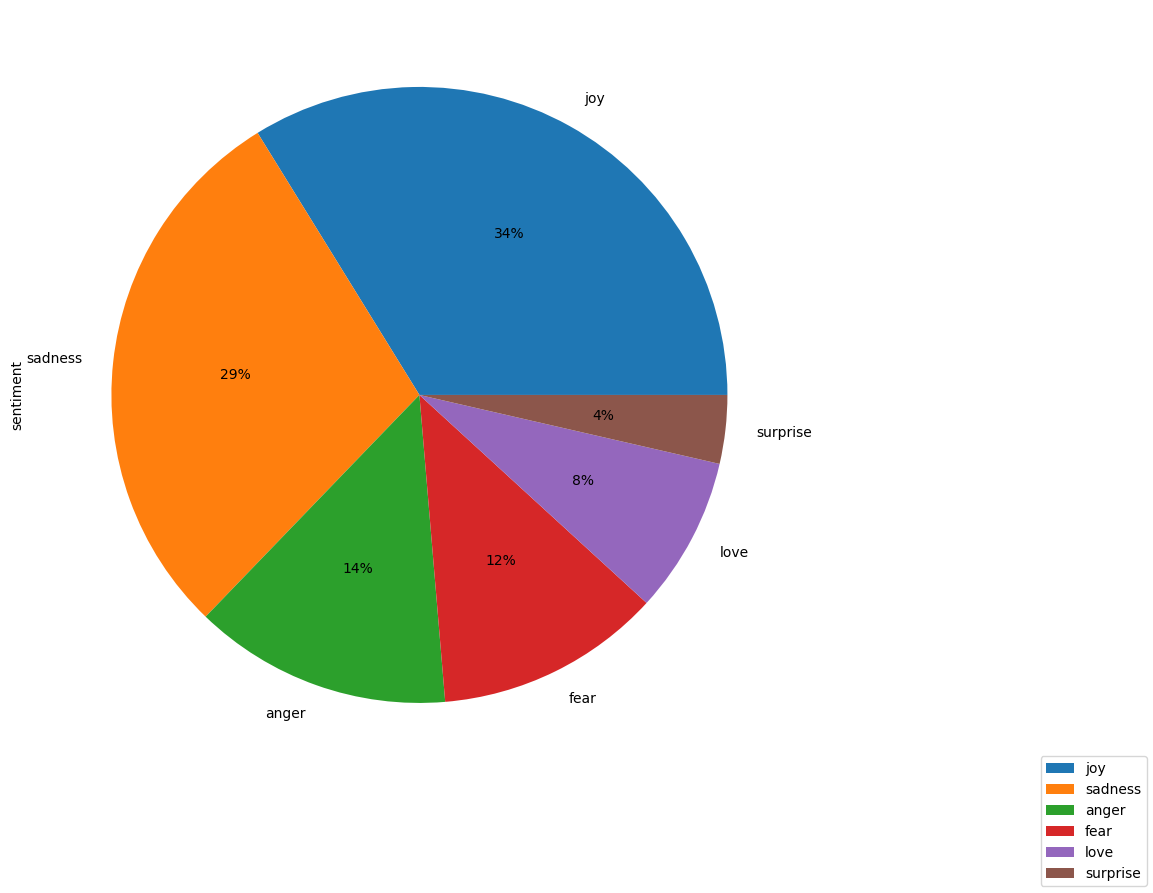

In [6]:
from sklearn.model_selection import train_test_split

train = pd.read_csv('train.txt', sep=';', names=['text', 'sentiment'])
test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
val = pd.read_csv('val.txt', sep=';', names=['text', 'sentiment'])

data = pd.concat([train, test, val])

_saveClassDistribution(data)


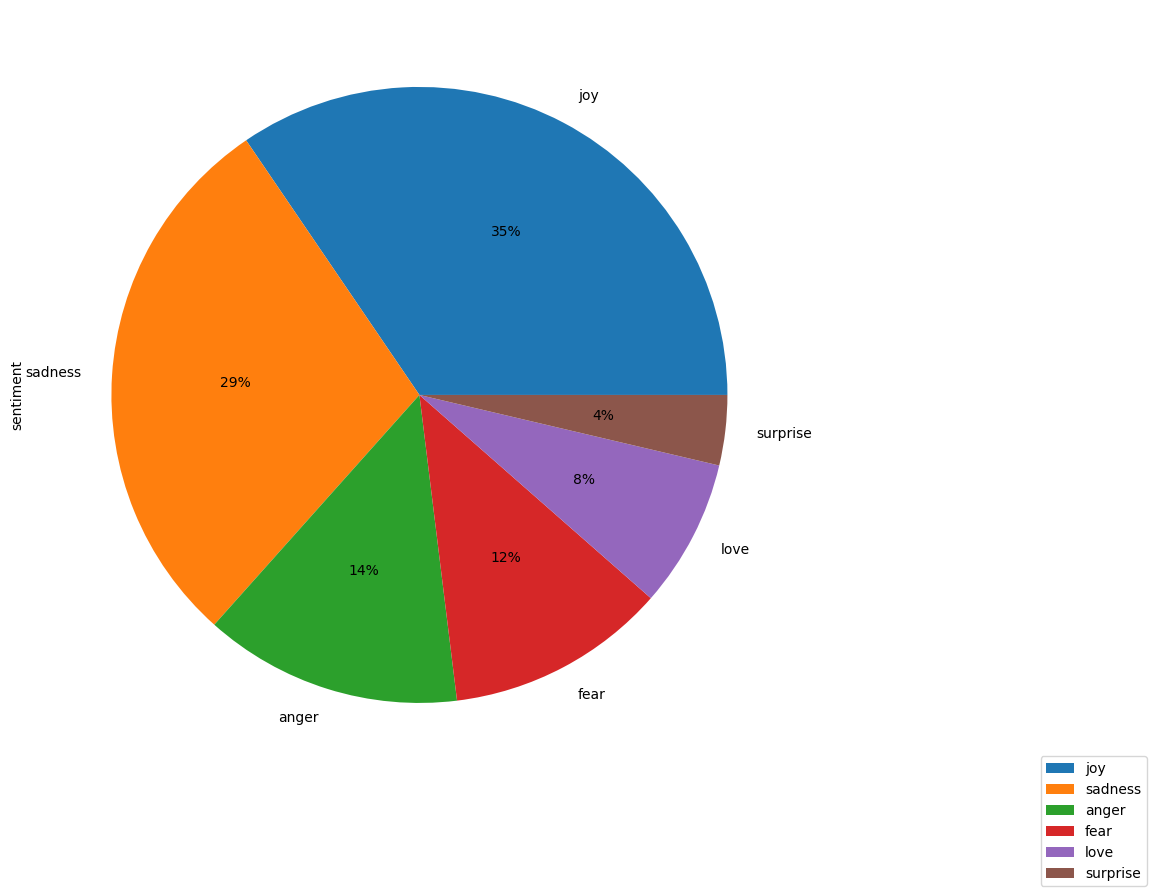

In [72]:
_saveClassDistribution(train)

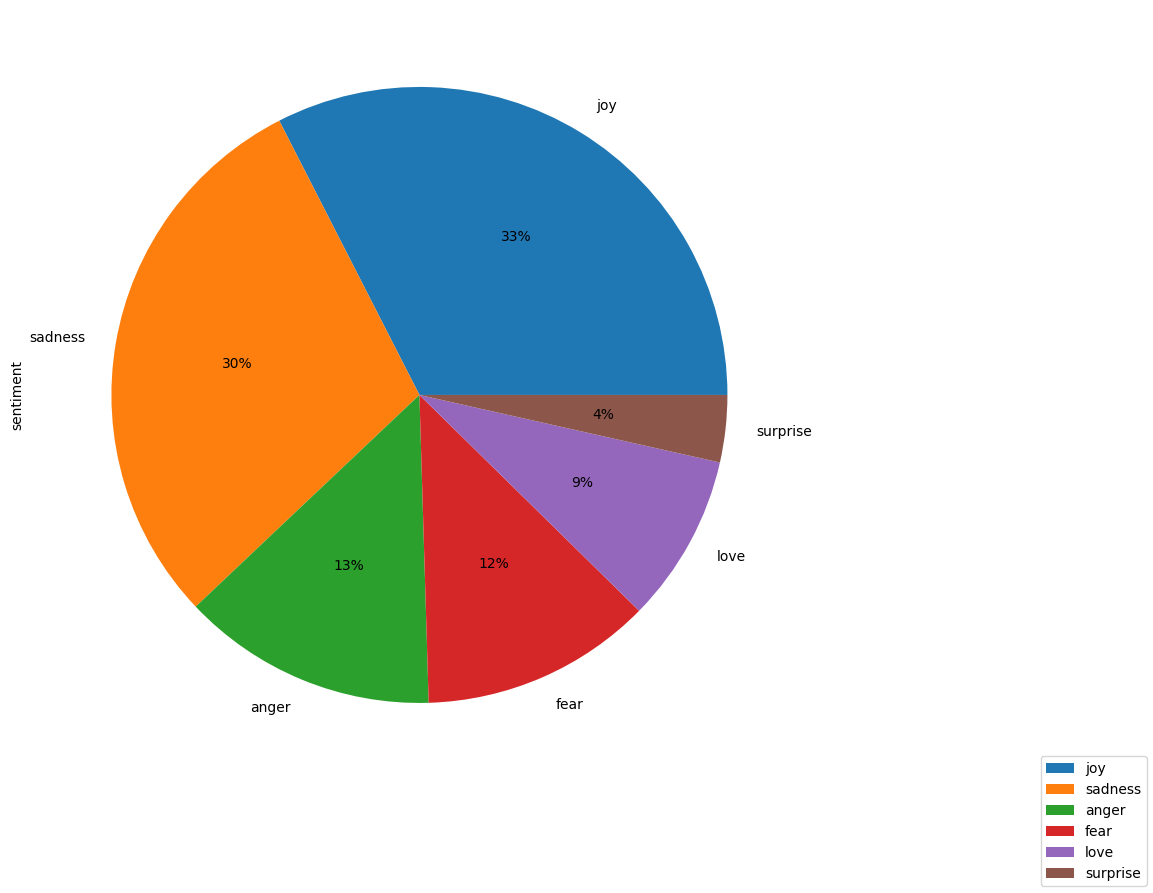

In [73]:
_saveClassDistribution(test)

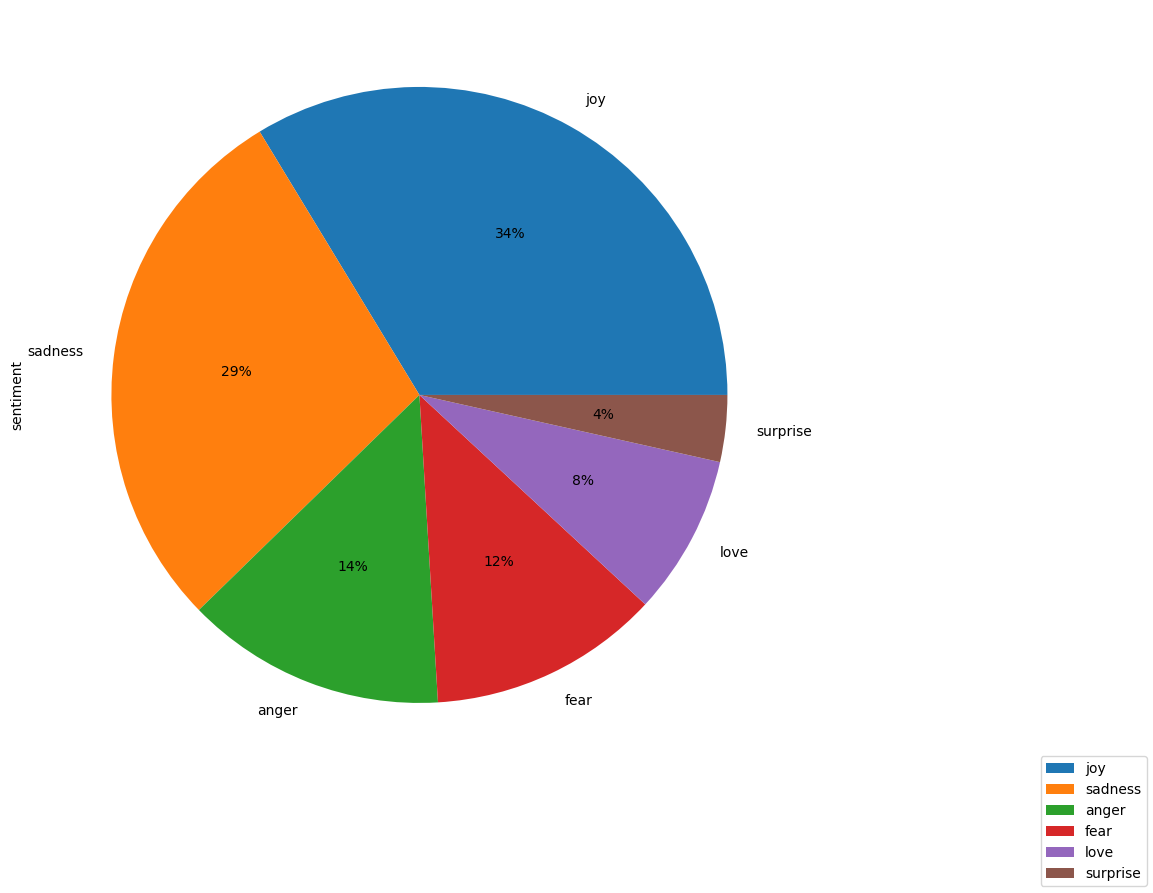

In [74]:
_saveClassDistribution(val)

In [75]:
xtrain, ytrain = preprocess(train, fns)
xtest, ytest = preprocess(test, fns)
xval, yval = preprocess(val, fns)

In [76]:
Embedding_dimensions = 100

Word2vec_train_data = list(map(lambda x: x.split(), xtrain))

In [77]:
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=10,
                 min_count=5)

In [78]:
print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 2389


In [79]:
input_length = 80

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [81]:
vocab_length = 50000
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
x_data = np.concatenate([xtrain, xtest, xval], axis=0)
tokenizer.fit_on_texts(x_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 50000


In [82]:
X_train = pad_sequences(tokenizer.texts_to_sequences(xtrain), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(xtest) , maxlen=input_length)
X_val  = pad_sequences(tokenizer.texts_to_sequences(xval) , maxlen=input_length)

In [83]:
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)
print("X_val.shape :", X_val.shape)

X_train.shape: (10000, 80)
X_test.shape : (5000, 80)
X_val.shape : (5000, 80)


In [84]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (50000, 100)


In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding, Input

In [86]:
embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)


In [57]:
def _makeModel3(layer):
    model = Sequential()
    model.add(layer)
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Conv1D(100, 5, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [58]:
model = _makeModel3(embedding_layer)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 100)           5000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 80, 200)          160800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 80, 200)          240800    
 nal)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 76, 100)           100100    
                                                                 
 global_max_pooling1d_6 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                      

In [59]:
hist = model.fit(
    X_train, ytrain,
    batch_size=1024,
    epochs=15,
    validation_data=(X_val, yval),
    verbose=1
)

Epoch 1/15
10/10 [==============================] - 7s 401ms/step - loss: 1.6351 - accuracy: 0.3294 - val_loss: 1.6175 - val_accuracy: 0.3258
Epoch 2/15
10/10 [==============================] - 3s 293ms/step - loss: 1.5852 - accuracy: 0.3406 - val_loss: 1.5910 - val_accuracy: 0.3258
Epoch 3/15
10/10 [==============================] - 3s 293ms/step - loss: 1.5749 - accuracy: 0.3472 - val_loss: 1.5832 - val_accuracy: 0.3258
Epoch 4/15
10/10 [==============================] - 3s 292ms/step - loss: 1.5726 - accuracy: 0.3470 - val_loss: 1.5907 - val_accuracy: 0.3258
Epoch 5/15
10/10 [==============================] - 3s 291ms/step - loss: 1.5717 - accuracy: 0.3470 - val_loss: 1.5848 - val_accuracy: 0.3258
Epoch 6/15
10/10 [==============================] - 3s 292ms/step - loss: 1.5693 - accuracy: 0.3466 - val_loss: 1.5849 - val_accuracy: 0.3238
Epoch 7/15
10/10 [==============================] - 3s 297ms/step - loss: 1.5690 - accuracy: 0.3468 - val_loss: 1.5822 - val_accuracy: 0.3258
Epoch 

In [60]:
model.save('model\emotions.tf', save_format='tf')
print("Model saved on disk.")

INFO:tensorflow:Assets written to: model\emotions.tf\assets


INFO:tensorflow:Assets written to: model\emotions.tf\assets


Model saved on disk.


In [61]:
def _testModel3(model, xtest, ytest):
    print("Testing the model...")
    print("The result obtained is:\n")
    model.evaluate(xtest, ytest)

    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    result = confusion_matrix(ytest, yprediction, normalize='pred')
    print(result)

    classes = ["joy", "anger", "love", "sadness", "fear", "surprise"]
    df_cfm = pd.DataFrame(result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig("evaluation\cfm.png")
    print("\nConfusion matrix saved on disk.\n")

    getClassificationReport3(yprediction, ytest)

def getClassificationReport3(yprediction, ytest):
    # yprediction = np.argmax(yprediction, axis=1)
    # ytest = np.argmax(ytest, axis=1)
    report = classification_report(ytest, yprediction)
    print(report)
    with io.open('evaluation/classificationreport.txt', 'w', encoding='utf-8') as f:
        f.write(report)


Testing the model...
The result obtained is:

157/157 [==============================] - 2s 8ms/step
[[0.3332 0.     0.     0.     0.     0.    ]
 [0.1348 0.     0.     0.     0.     0.    ]
 [0.0844 0.     0.     0.     0.     0.    ]
 [0.2972 0.     0.     0.     0.     0.    ]
 [0.1142 0.     0.     0.     0.     0.    ]
 [0.0362 0.     0.     0.     0.     0.    ]]

Confusion matrix saved on disk.

              precision    recall  f1-score   support

           0       0.33      1.00      0.50      1666
           1       0.00      0.00      0.00       674
           2       0.00      0.00      0.00       422
           3       0.00      0.00      0.00      1486
           4       0.00      0.00      0.00       571
           5       0.00      0.00      0.00       181

    accuracy                           0.33      5000
   macro avg       0.06      0.17      0.08      5000
weighted avg       0.11      0.33      0.17      5000



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


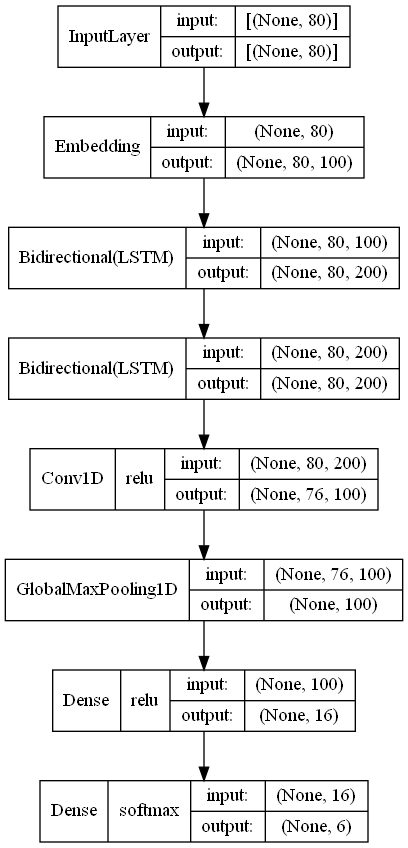

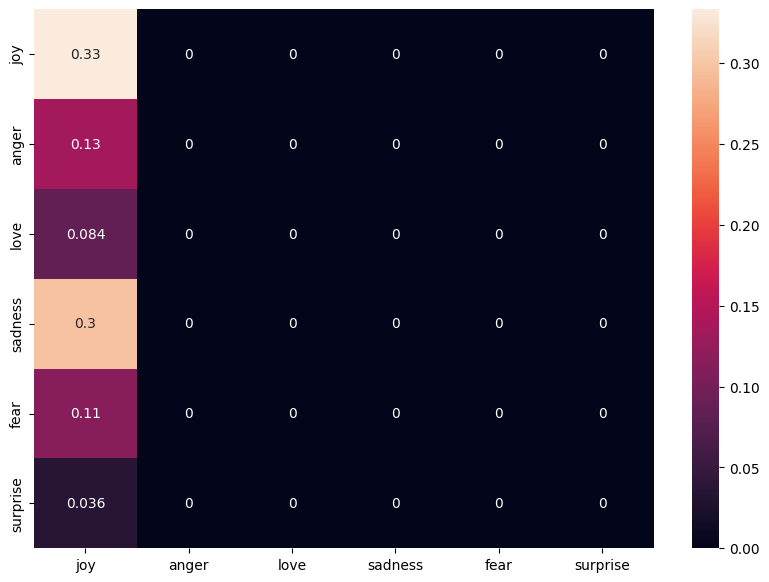

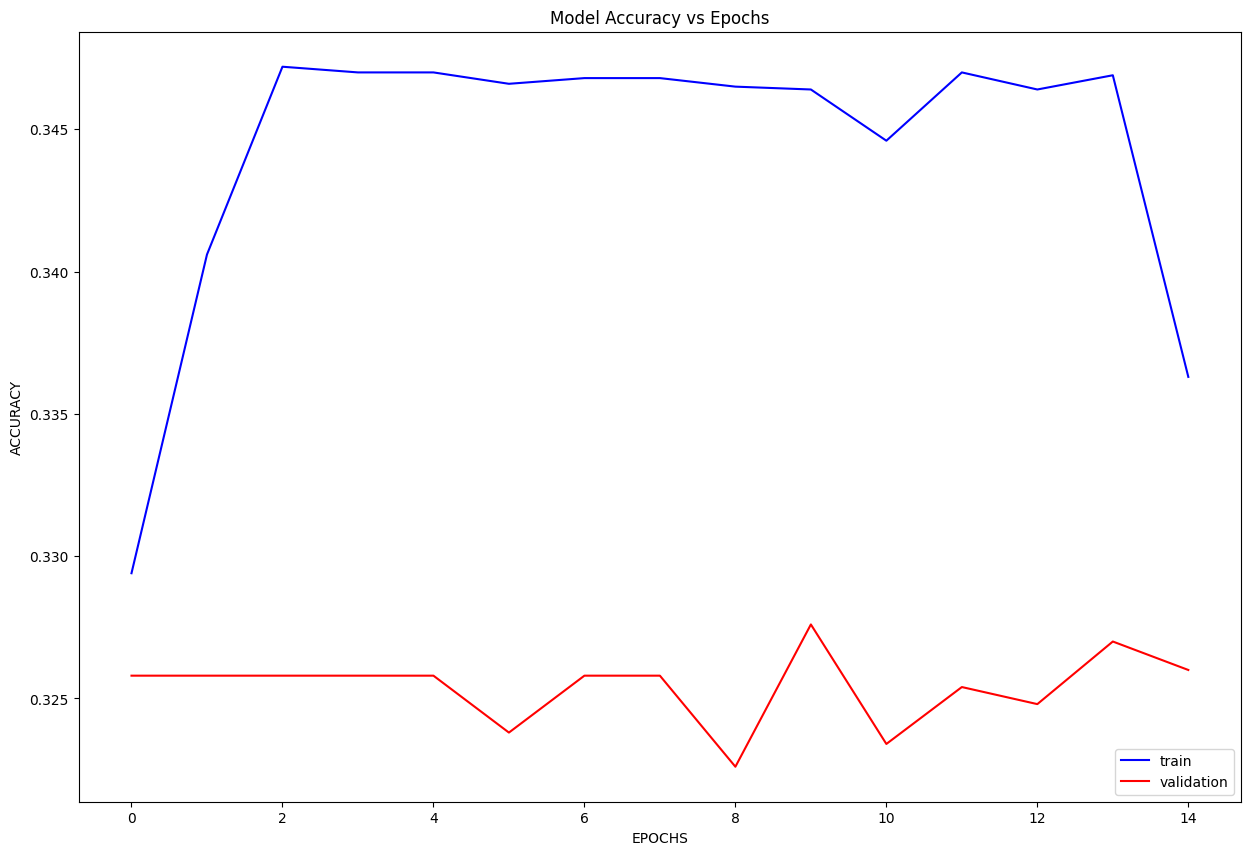

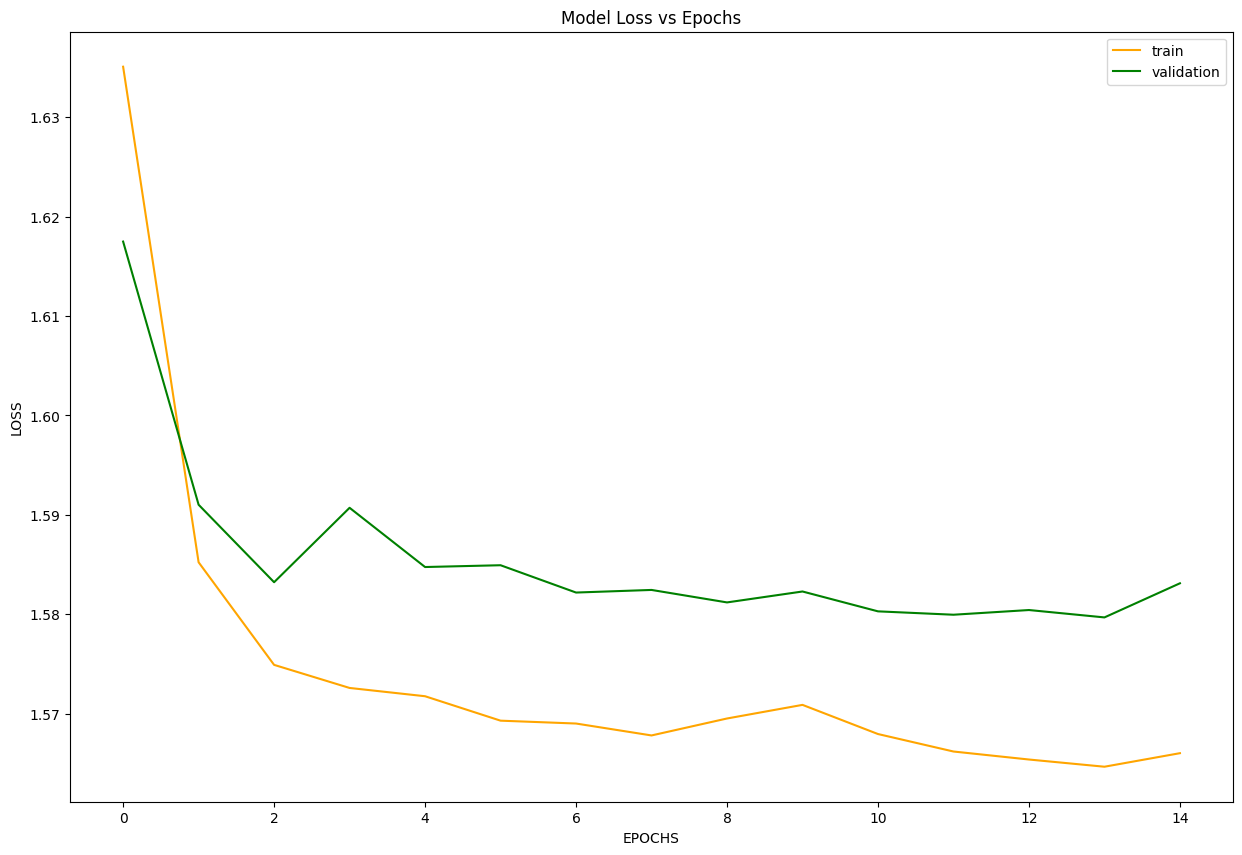

In [62]:
_testModel3(model, X_test, ytest)
_saveFigures(hist)
plot_model(model=model, to_file='model\model.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)


Epoch 1/50
625/625 [==============================] - 2s 3ms/step - loss: 1.7923 - accuracy: 0.2237 - val_loss: 1.6913 - val_accuracy: 0.2878
Epoch 2/50
625/625 [==============================] - 2s 3ms/step - loss: 1.6953 - accuracy: 0.2887 - val_loss: 1.6550 - val_accuracy: 0.2964
Epoch 3/50
625/625 [==============================] - 2s 2ms/step - loss: 1.6666 - accuracy: 0.3012 - val_loss: 1.6393 - val_accuracy: 0.3334
Epoch 4/50
625/625 [==============================] - 2s 2ms/step - loss: 1.6480 - accuracy: 0.3026 - val_loss: 1.6299 - val_accuracy: 0.3380
Epoch 5/50
625/625 [==============================] - 2s 2ms/step - loss: 1.6398 - accuracy: 0.3068 - val_loss: 1.6240 - val_accuracy: 0.3362
Epoch 6/50
625/625 [==============================] - 2s 2ms/step - loss: 1.6340 - accuracy: 0.3100 - val_loss: 1.6197 - val_accuracy: 0.3374
Epoch 7/50
625/625 [==============================] - 2s 2ms/step - loss: 1.6309 - accuracy: 0.3197 - val_loss: 1.6144 - val_accuracy: 0.3366
Epoch 

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


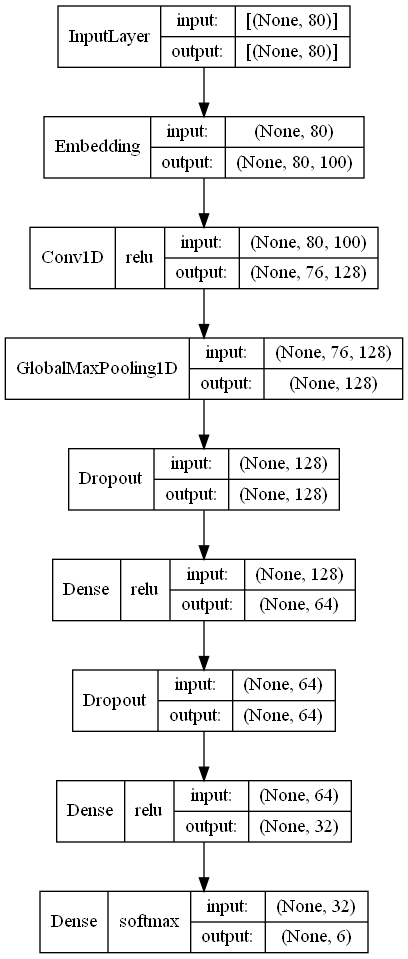

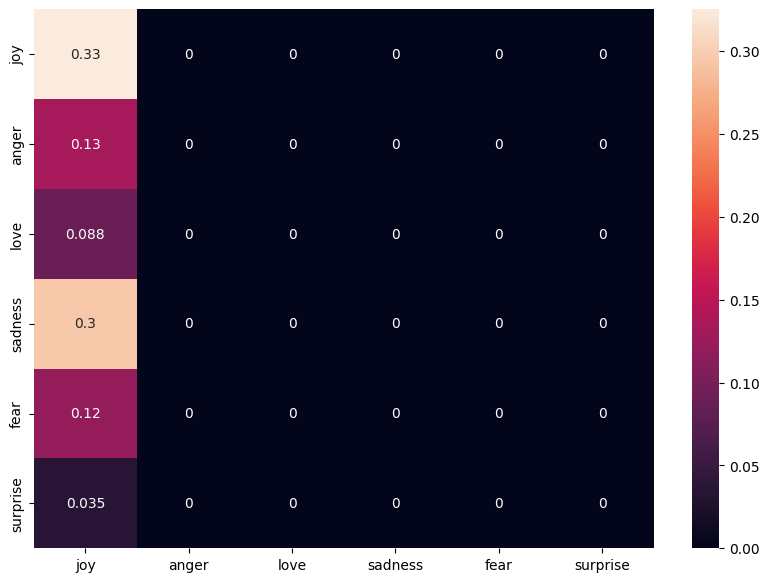

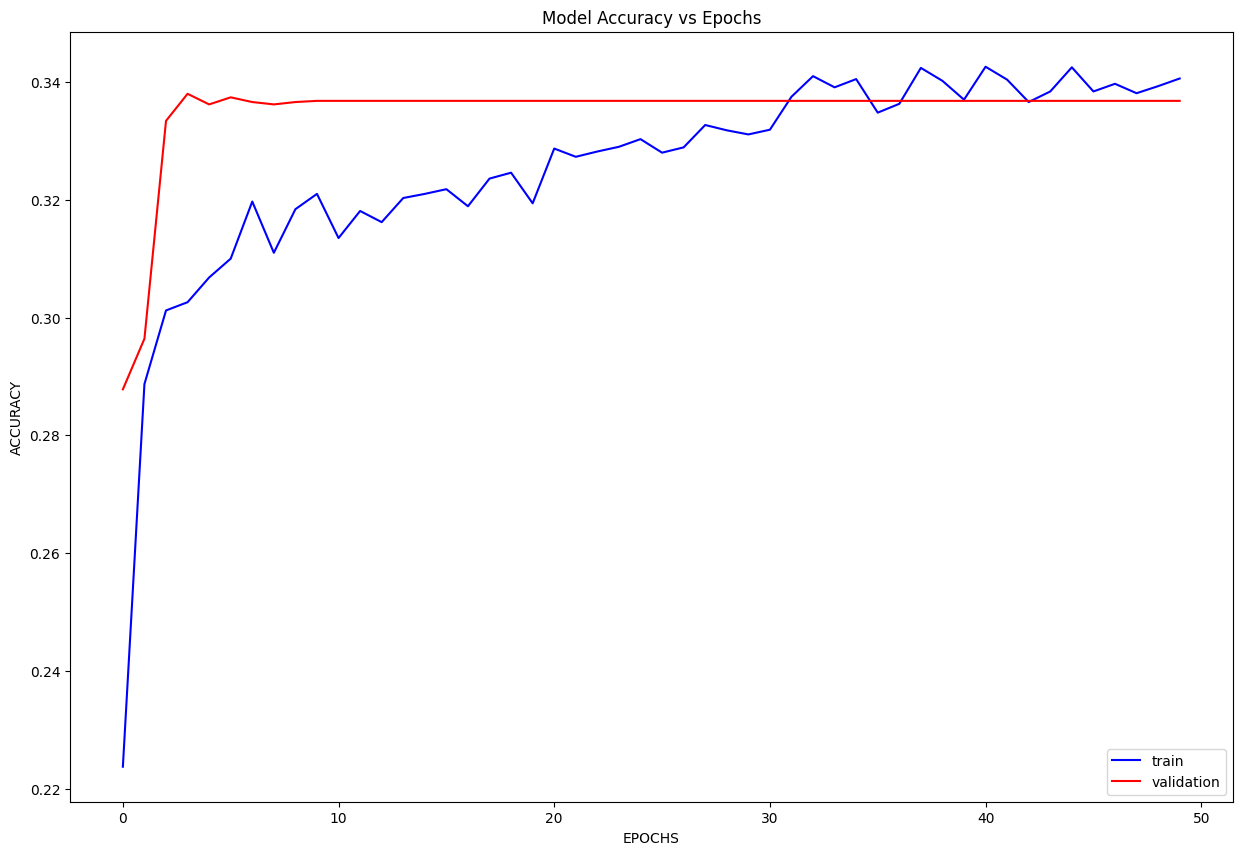

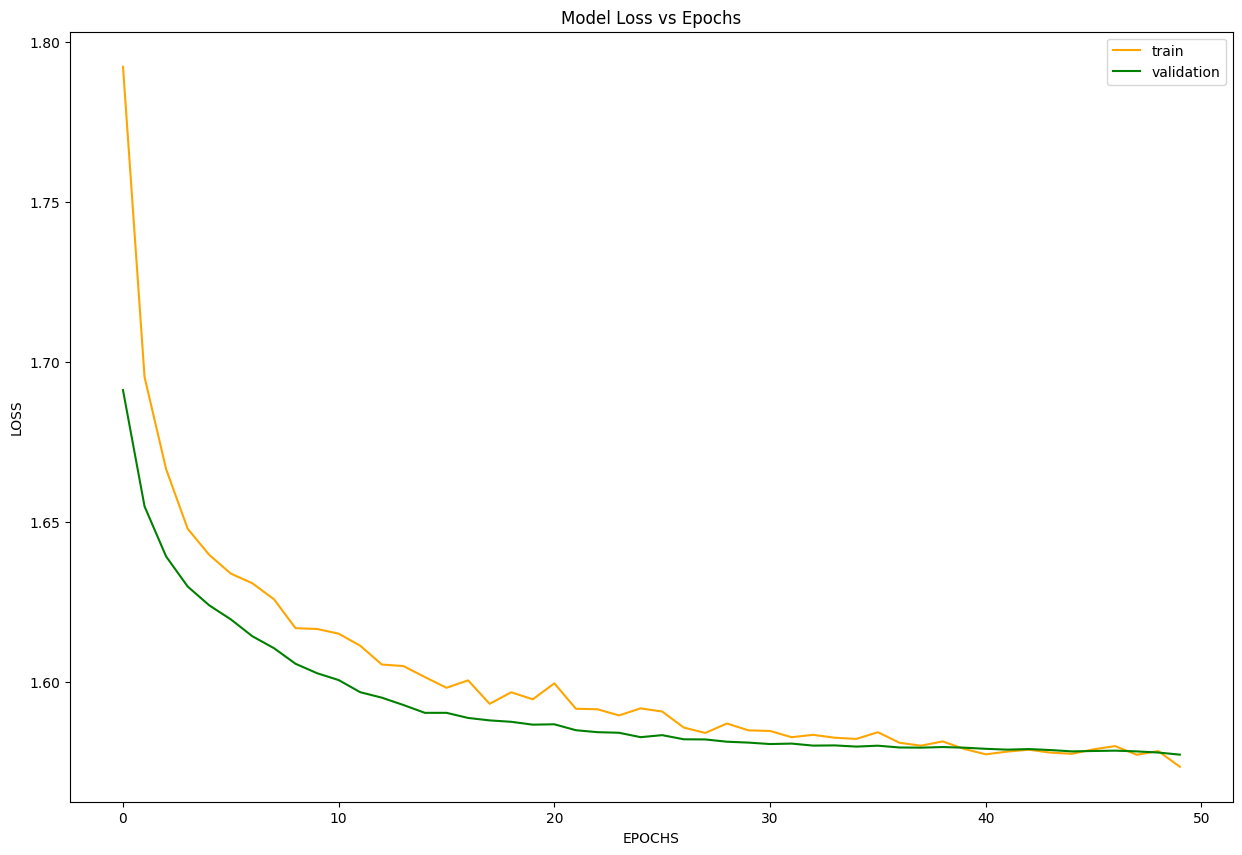

In [91]:
from keras.optimizers import Adam

model_new = Sequential()
model_new.add(embedding_layer)
model_new.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_new.add(GlobalMaxPool1D())
model_new.add(Dropout(0.3))
model_new.add(Dense(64, activation='relu'))
model_new.add(Dropout(0.5))
model_new.add(Dense(32, activation='relu'))
model_new.add(Dense(6, activation='softmax'))
model_new.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy',
                  metrics=['accuracy'])

hist2 = model_new.fit(
    X_train, ytrain,
    batch_size=16,
    epochs=50,
    validation_data=(X_val, yval),
    verbose=1
)

_testModel3(model_new, X_test, ytest)
_saveFigures(hist2)
plot_model(model=model_new, to_file='model\model_new.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)

# JOVO NANOVO

In [13]:
%%time


import gensim.downloader as api
import matplotlib.pyplot as plt
import text_hammer as th


from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

df_cleaned_train = text_preprocessing(train, 'text')

df_cleaned_train['sentiment'] = df_cleaned_train.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
test['sentiment'] = test.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
val['sentiment'] = val.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3, 'fear':4,'surprise':5})

from keras.utils import to_categorical
ytrain = to_categorical(df_cleaned_train.sentiment.values)
ytest = to_categorical(test.sentiment.values)
yval = to_categorical(val.sentiment.values)

num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
tokenizer.fit_on_texts(data)

X_train=tokenizer.texts_to_sequences(df_cleaned_train['text']) # this converts texts into some numeric sequences 
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post') # this makes the length of all numeric sequences equal 
X_test = tokenizer.texts_to_sequences(test['text'])
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(val['text'])
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

embeddings_index = {}
file_ = open("./glove/glove.6B/glove.6B.300d.txt", encoding="utf8")
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()

# glove_gensim  = api.load('glove-wiki-gigaword-100')
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape
for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            gensim_weight_matrix[index] = embedding_vector
        else:
            gensim_weight_matrix[index] = np.zeros(100)

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout

EMBEDDING_DIM = 300
class_num = 6
model = Sequential()
model.add(Input(shape=(EMBEDDING_DIM, )))
model.add(Embedding(input_dim = num_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(class_num, activation = 'softmax'))

model.layers[0].set_weights([gensim_weight_matrix])
model.layers[0].trainable = False

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

history_embedding = model.fit(X_train_pad, ytrain, 
                                epochs = 25, batch_size = 120, 
                                validation_data=(X_val_pad, yval),
                                verbose = 1, callbacks= [es, mc]  )

plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

y_pred = np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(ytest, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

Epoch 1/25
134/134 [==============================] - ETA: 0s - loss: 1.5883 - accuracy: 0.3293
Epoch 1: val_accuracy improved from -inf to 0.35200, saving model to .\model.h5
134/134 [==============================] - 46s 311ms/step - loss: 1.5883 - accuracy: 0.3293 - val_loss: 1.5841 - val_accuracy: 0.3520
Epoch 2/25
 46/134 [=========>....................] - ETA: 25s - loss: 1.5926 - accuracy: 0.3313

KeyboardInterrupt: 